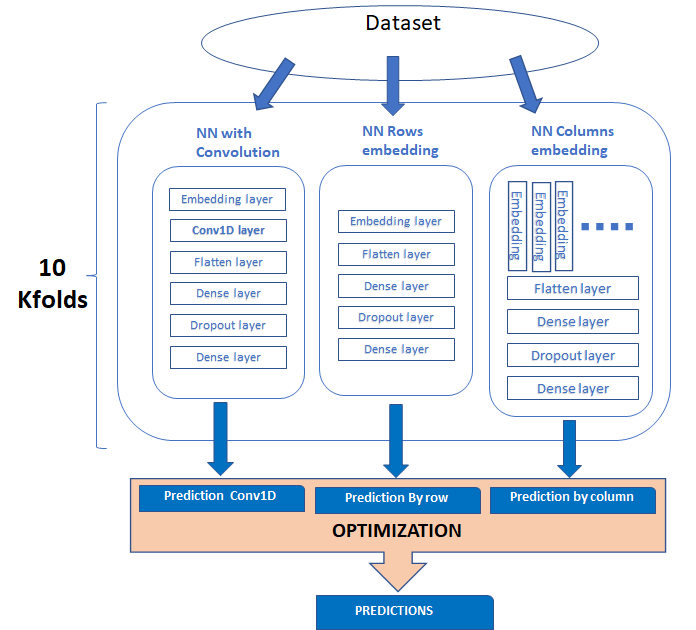

<h3> Adapted from Alexander Ryzhkov python translation of Oscar Villarreal Escamilla Notebook

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss

import gc

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers

from keras.models import Model


In [ ]:
train = pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv')
test = pd.read_csv("../input/tabular-playground-series-jun-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-jun-2021/sample_submission.csv")
submission = submission.set_index('id')


In [ ]:
targets = pd.get_dummies(train['target'])

In [ ]:
def custom_metric(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-15, 1-1e-15)
    loss = K.mean(cce(y_true, y_pred))
    return loss

cce = tf.keras.losses.CategoricalCrossentropy()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_custom_metric', min_delta=1e-05, patience=5, verbose=0,
    mode='min', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_custom_metric', factor=0.7, patience=2, verbose=0,
    mode='min')

In [ ]:
def model_NN_by_row():
    model_NN_by_row_inputs = layers.Input(shape = (75,))
    embed = layers.Embedding(354, 7)(model_NN_by_row_inputs)
    embed = layers.Flatten()(embed)
    hidden = layers.Dropout(0.3)(embed)
    hidden = tfa.layers.WeightNormalization(layers.Dense(units=64, activation='selu', kernel_initializer="lecun_normal"))(hidden)
    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    output = tfa.layers.WeightNormalization(layers.Dense(units=64, activation='relu',kernel_initializer="lecun_normal"))(output) 
    output = layers.Dropout(0.4)(layers.Concatenate()([embed, hidden, output]))  
    output = tfa.layers.WeightNormalization(layers.Dense(units=64, activation='elu',kernel_initializer="lecun_normal"))(output)
    model_NN_by_row_outputs = layers.Dense(9, activation='softmax',kernel_initializer="lecun_normal")(output)
    
    model = Model(model_NN_by_row_inputs,model_NN_by_row_outputs)
    
    return model

In [ ]:
def model_NN_by_column():
    model_NN_by_column_inputs = layers.Input(shape = (75,))
    b = layers.Reshape((-1,1))( model_NN_by_column_inputs)
    b = layers.Embedding(354, 7)(b)
    embed = layers.Flatten()(b)
    hidden = layers.Dropout(0.3)(embed)
    hidden = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='selu', kernel_initializer="lecun_normal"))(hidden)
    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    output = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='relu',kernel_initializer="lecun_normal"))(output) 
    output = layers.Dropout(0.4)(layers.Concatenate()([embed, hidden, output]))
    output = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='elu',kernel_initializer="lecun_normal"))(output)
    model_NN_by_column_outputs = layers.Dense(9, activation='softmax',kernel_initializer="lecun_normal")(output)
    
    model = Model (model_NN_by_column_inputs,model_NN_by_column_outputs)
    
    return model

In [ ]:
def conv_model():

    conv_inputs = layers.Input(shape = (75))
    embed = layers.Embedding (input_dim=354, output_dim=7,
                              embeddings_regularizer='l2')(conv_inputs)
    embed = layers.Conv1D(12,1,activation='relu',)(embed)        
    embed = layers.Flatten()(embed)
    hidden = layers.Dropout(0.3)(embed)
    hidden = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='selu', kernel_initializer="lecun_normal"))(hidden)
    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    output = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='relu',kernel_initializer="lecun_normal"))(output) 
    output = layers.Dropout(0.4)(layers.Concatenate()([embed, hidden, output]))
    output = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='elu',kernel_initializer="lecun_normal"))(output)
    conv_outputs = layers.Dense(9, activation='softmax',kernel_initializer="lecun_normal")(output)
    
    model = Model(conv_inputs,conv_outputs)
    
    return model

In [ ]:
oof_NN_a = np.zeros((train.shape[0],9))
pred_NN_a = np.zeros((test.shape[0],9))

oof_NN_h = np.zeros((train.shape[0],9))
pred_NN_h = np.zeros((test.shape[0],9))

oof_NN_v = np.zeros((train.shape[0],9))
pred_NN_v = np.zeros((test.shape[0],9))

NN_h_train_preds = []
NN_h_test_preds = []

NN_v_train_preds = []
NN_v_test_preds = []

NN_a_train_preds = []
NN_a_test_preds = []

N_FOLDS = 10
SEED = 2021
EPOCH = 50


skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (tr_idx, ts_idx) in enumerate(skf.split(train,train.iloc[:,-1])):
    print(f"\n ====== TRAINING FOLD {fold} =======\n")

    X_train = train.iloc[:,1:-1].iloc[tr_idx]
    y_train = targets.iloc[tr_idx]
    X_test = train.iloc[:,1:-1].iloc[ts_idx]
    y_test = targets.iloc[ts_idx]

    K.clear_session()

    #================= NN CONV MODEL training =========
    
    print("\n-----Convolution model Training----\n")

    model_conv = conv_model()

    model_conv.compile(loss='categorical_crossentropy', 
                            optimizer = keras.optimizers.Adam(learning_rate=2e-4), 
                            metrics=custom_metric)
    model_conv.fit(X_train, y_train,
              batch_size = 256, epochs = EPOCH,
              validation_data=(X_test, y_test),
              callbacks=[es, plateau],
              verbose = 0)
   
    #============== Convolution Model prediction ==========

    pred_a = model_conv.predict(X_test) 
    oof_NN_a[ts_idx] += pred_a 
    score_NN_a = log_loss(y_test, pred_a)
    print(f"\nFOLD {fold} Score convolution model: {score_NN_a}\n")
    pred_NN_a += model_conv.predict(test.iloc[:,1:]) / N_FOLDS 

 
    #================= By column MODELS training ==================

    print("\n-----By column NN model Training----\n")

    model_by_col = model_NN_by_column()

    model_by_col.compile(loss='categorical_crossentropy', 
                         optimizer = keras.optimizers.Adam(learning_rate=2e-4), 
                         metrics=custom_metric)

    model_by_col.fit(X_train,y_train,
            validation_data=(X_test,y_test),
            epochs=EPOCH,
            verbose=0,
            batch_size = 256,
            callbacks=[es,plateau])
    
    #============= By column NN Model prediction =============
    
    pred_col = model_by_col.predict(X_test)
    oof_NN_v[ts_idx] = pred_col 
    score_NN_v = log_loss(y_test,  pred_col)
    print(f"\nFOLD {fold} Score by column embedding model: {score_NN_v}\n")
    pred_NN_v += model_by_col.predict(test.iloc[:,1:]) / N_FOLDS 
    
   
    #================= By row MODELS training ==================
    
    print("\n-----By row NN model Training----\n")

    model_by_r = model_NN_by_row()

    model_by_r.compile(loss='categorical_crossentropy', 
                        optimizer = keras.optimizers.Adam(learning_rate=2e-4), 
                        metrics=custom_metric)

    model_by_r.fit(X_train,y_train,
            validation_data=(X_test,y_test),
            epochs=EPOCH,
            verbose=0,
            batch_size = 256,
            callbacks=[es,plateau])
    
     #============= By row NN Model prediction =============

    pred_row = model_by_r.predict(X_test)
    oof_NN_h[ts_idx] = pred_row 
    score_NN_h = log_loss(y_test, pred_row)
    print(f"\nFOLD {fold} Score by row embedding model: {score_NN_h}\n")
    pred_NN_h += model_by_r.predict(test.iloc[:,1:]) / N_FOLDS  
    
    # =========PREPROCESSING FOR FUTURE OPTIMIZATION===========
    
    NN_a_train_preds.append(oof_NN_a[ts_idx])
    NN_a_test_preds.append(model_conv.predict(test.iloc[:,1:]))

    NN_h_train_preds.append(oof_NN_h[ts_idx])
    NN_h_test_preds.append(model_by_r.predict(test.iloc[:,1:]))

    NN_v_train_preds.append(oof_NN_v[ts_idx])
    NN_v_test_preds.append(model_by_col.predict(test.iloc[:,1:]))
    #___________________________________________________________
    
score_NN_h = log_loss(targets, oof_NN_h)
print(f"\n=== FINAL SCORE BY ROW EMBEDDING MODEL : {score_NN_h}===\n") 

score_NN_v = log_loss(targets, oof_NN_v)
print(f"\n=== FINAL SCORE BY COLUMN EMBEDDING MODEL : {score_NN_v}===\n")
    
score_a = log_loss(targets, oof_NN_a)
print(f"\n=== FINAL SCORE CONVOLUTION MODEL : {score_a}===\n") 

In [ ]:
# From Ryan Barretto notebook :
train_features = train.drop(['target', 'id'], axis=1).values
test_features = test.drop('id', axis=1).values
target = train['target'].values

In [ ]:
def class_to_num(classes):
    return [int(word[-1]) for word in classes]

def num_to_class(nums):
    return ['Class_' + str(num) for num in nums]

labels = np.array(class_to_num(target))

labels = pd.DataFrame(labels)

In [ ]:
y_valids = []
for fold, (train_index, test_index) in enumerate(skf.split(train_features, labels)):
        
    y_valid = labels.iloc[test_index]
    y_valids.append(y_valid)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import minimize
scores = []
weights = []
for y, NN_v_pred, NN_h_pred, NN_a_pred in zip(y_valids, 
                                        NN_v_train_preds, 
                                        NN_h_train_preds, 
                                        NN_a_train_preds,
                                        ):
    preds = []
    preds.append(NN_v_pred)
    preds.append(NN_h_pred)
    preds.append(NN_a_pred)
    
    def log_weight_loss(weights):
        weighted_pred = (weights[0]*preds[0]) + (weights[1]*preds[1]) + (weights[2]*preds[2])
        return log_loss(y, weighted_pred)
    starting_values = [0.4]*len(preds) 
    cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
    bounds = [(0,1)]*len(preds) 
    res = minimize(log_weight_loss, starting_values, method='Nelder-Mead', bounds=bounds, constraints=cons)
    
    weights.append(res['x'])
    print(res['fun'])
    scores.append(res['fun'])

In [ ]:
folds = N_FOLDS
final_weights = sum(weights)/folds
weighted_preds = np.array((final_weights[0] * sum(np.array(NN_v_test_preds)/folds))
                           +(final_weights[1] * sum(np.array(NN_h_test_preds)/folds))
                           +(final_weights[2] * sum(np.array(NN_a_test_preds)/folds)))

In [ ]:
submission[['Class_1', 'Class_2', 'Class_3', 'Class_4','Class_5','Class_6','Class_7','Class_8','Class_9']] = weighted_preds
submission.to_csv('submission_NN_blending4.csv')